#### Check BC LENS2
This program reads in hail predictor variables from ERA5 and LENS2 before and after BC  
- 1 Read LENS2 variables
- 2 Read and remap ERA5 hail predictors to LENS2 grid
- 3 CMP
  - Before BC
      - ERA5 climate vs. LENS2 climate
      -  LENS2 current climate vs. future climate
  - After BC
    - ERA5 vs. LENS2 BC (same)
    - LENS2 current climate BC vs. future climate BC
 
Ming Ge Aug. 2024

In [1]:
import numpy
import datetime
import os
import glob
from calendar import isleap
from tqdm import tqdm
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### Setups

In [2]:
year_s = 1960
year_e = 2014
n_year = year_e - year_s + 1

time_1d = pd.date_range(datetime.datetime(year_s, 1, 1, 0),
                     end=datetime.datetime(year_e, 12, 31, 23), freq='d')
time_6h = pd.date_range(datetime.datetime(year_s, 1, 1, 0),
                     end=datetime.datetime(year_e, 12, 31, 23), freq='6h')
n_day = len(time_1d)

# variables from ERA5
# /glade/u/home/prein/projects/2024/2024_ML-Hail-Model/programs/    Boris_code  LENS2_evaluation
# from /glade/u/home/prein/projects/2023/2023_Boris-Hail/programs
dir_e5 = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/QBE/data_on_LENS2/'
dir_lens2     = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/hour_6/'
dir_o         = '/glade/campaign/mmm/c3we/mingge/QBE/'

# no leap year
time_1d_nl = time_1d[(time_1d.month != 2) | (time_1d.day != 29)]
time_6h_nl = time_6h[(time_6h.month != 2) | (time_6h.day != 29)]
n_day_nl = int(len(time_6h_nl)/4)

years = np.unique(time_6h.year)

#### 1.1 Read current LENS2 variables

In [3]:
lens_var_names = ['CAPEmax',
                'FLH',
                'CINmax',
                'VS06',
                'TotalTotal',
                'RH850']
n_var = len(lens_var_names)
n_mem = 1
mem_s = '08'
flnm_lens2 = dir_o + 'hailpredictors_lens_31window_' + mem_s + '.nc'

with xr.open_dataset(flnm_lens2) as ds:
    #print(ds)
    lon_lens_1d = np.array(ds["lon"])
    lat_lens_1d = np.array(ds["lat"])
    n_lat_lens = len(lat_lens_1d)
    n_lon_lens = len(lon_lens_1d)
    lens_current = np.reshape(ds.hailpredictors[:,:,15].data,  (n_day_nl, n_lat_lens, n_lon_lens, n_var, n_mem))   

lon_lens, lat_lens = np.meshgrid(lon_lens_1d, lat_lens_1d)

flnm_current_bc = dir_o + 'hailpredictors_lens_' + mem_s + '_corrected.nc'
with xr.open_dataset(flnm_current_bc) as ds:
    lens_current_bc = np.reshape(ds.hailpredictors.data,  (n_day_nl, n_lat_lens, n_lon_lens, n_var, n_mem))


#### 1.2 read LENS2 Future Senario

In [4]:
files = glob.glob(dir_o + 'hailpredictors_lens_31window_2*' +mem_s+'.nc')
n_f = len(files)

for nf in range(n_f):
    with xr.open_dataset(files[nf]) as ds:
        data = ds.hailpredictors[:,:,15].data
        data_t = np.reshape(data, (data.shape[0]*data.shape[1], n_lat_lens, n_lon_lens, n_var, n_mem))
        if nf==0:
            lens_future = data_t
        else:
            lens_future = np.append(lens_future,data_t, axis=0)

In [5]:
files = glob.glob(dir_o + 'hailpredictors_2*' +mem_s+'_corrected.nc')
n_f = len(files)
for nf in range(n_f):
    with xr.open_dataset(files[nf]) as ds:
        data = ds.hailpredictors.data
        data_t = np.reshape(data, (data.shape[0]*data.shape[1], n_lat_lens, n_lon_lens, n_var, n_mem))
        if nf==0:
            lens_future_bc = data_t
        else:
            lens_future_bc = np.append(lens_future_bc,data_t, axis=0)

#### 2 Read and remap ERA5 hail predictors to LENS2 grid

In [6]:
# Save Latitude, Longitude and Height in arrays
rgsERAdata = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/'
sERAconstantFields = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc'
ncid = Dataset(sERAconstantFields, mode='r')
lat_era = np.squeeze(ncid.variables['latitude'][:])
lon_era = np.squeeze(ncid.variables['longitude'][:])
rgrHeight = (np.squeeze(ncid.variables['Z'][:,:,:]))/9.81
ncid.close()

lon_era, lat_era = np.meshgrid(lon_era, lat_era)

# find CONUS in ERA5
era_w = np.where(lon_lens[0,0] <= lon_era[0,:])[0][0]
era_e = np.where(lon_lens[0,-1] <= lon_era[0,:])[0][0]
era_n = np.where(lat_lens[0,0] >= lat_era[:,0])[0][0]
era_s = np.where(lat_lens[-1,0] >= lat_era[:,0])[0][0]

lat_era = lat_era[era_s:era_n, era_w:era_e]
lon_era = lon_era[era_s:era_n, era_w:era_e]

In [7]:
rgrERAVarall=np.zeros((n_day_nl, n_var, n_lat_lens, n_lon_lens))
iyear=0
 
for yy in range(n_year):
    iday=0
    outfile = dir_e5 + 'ERA5_LENS2_predictors_' + str(years[yy])+'.npz'
    #print(outfile)
    yearlength=365 + isleap(years[yy])

    # remove leap day
    data_tmp = np.load(outfile)
    if isleap(years[yy]):
        rgrERAVarall[iyear:iyear+365,:,:,:] = np.delete(data_tmp['rgrERAVarsyy'], 60, 0)
    else:    
        rgrERAVarall[iyear:iyear+365,:,:,:] = data_tmp['rgrERAVarsyy']
    lat_lens = data_tmp['lat_lens']
    lon_lens = data_tmp['lon_lens']
    #time_1d = pd.to_datetime(data_tmp['time_1d'])
    iyear=iyear+365

# replace CIN NANs with zeros
rgrERAVarall[:,lens_var_names.index('CINmax'),:,][np.isnan(rgrERAVarall[:,lens_var_names.index('CINmax'),:,:])] = 0

#### 3) Verification
- ERA5 Climate vs. LENS2 Climate

100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


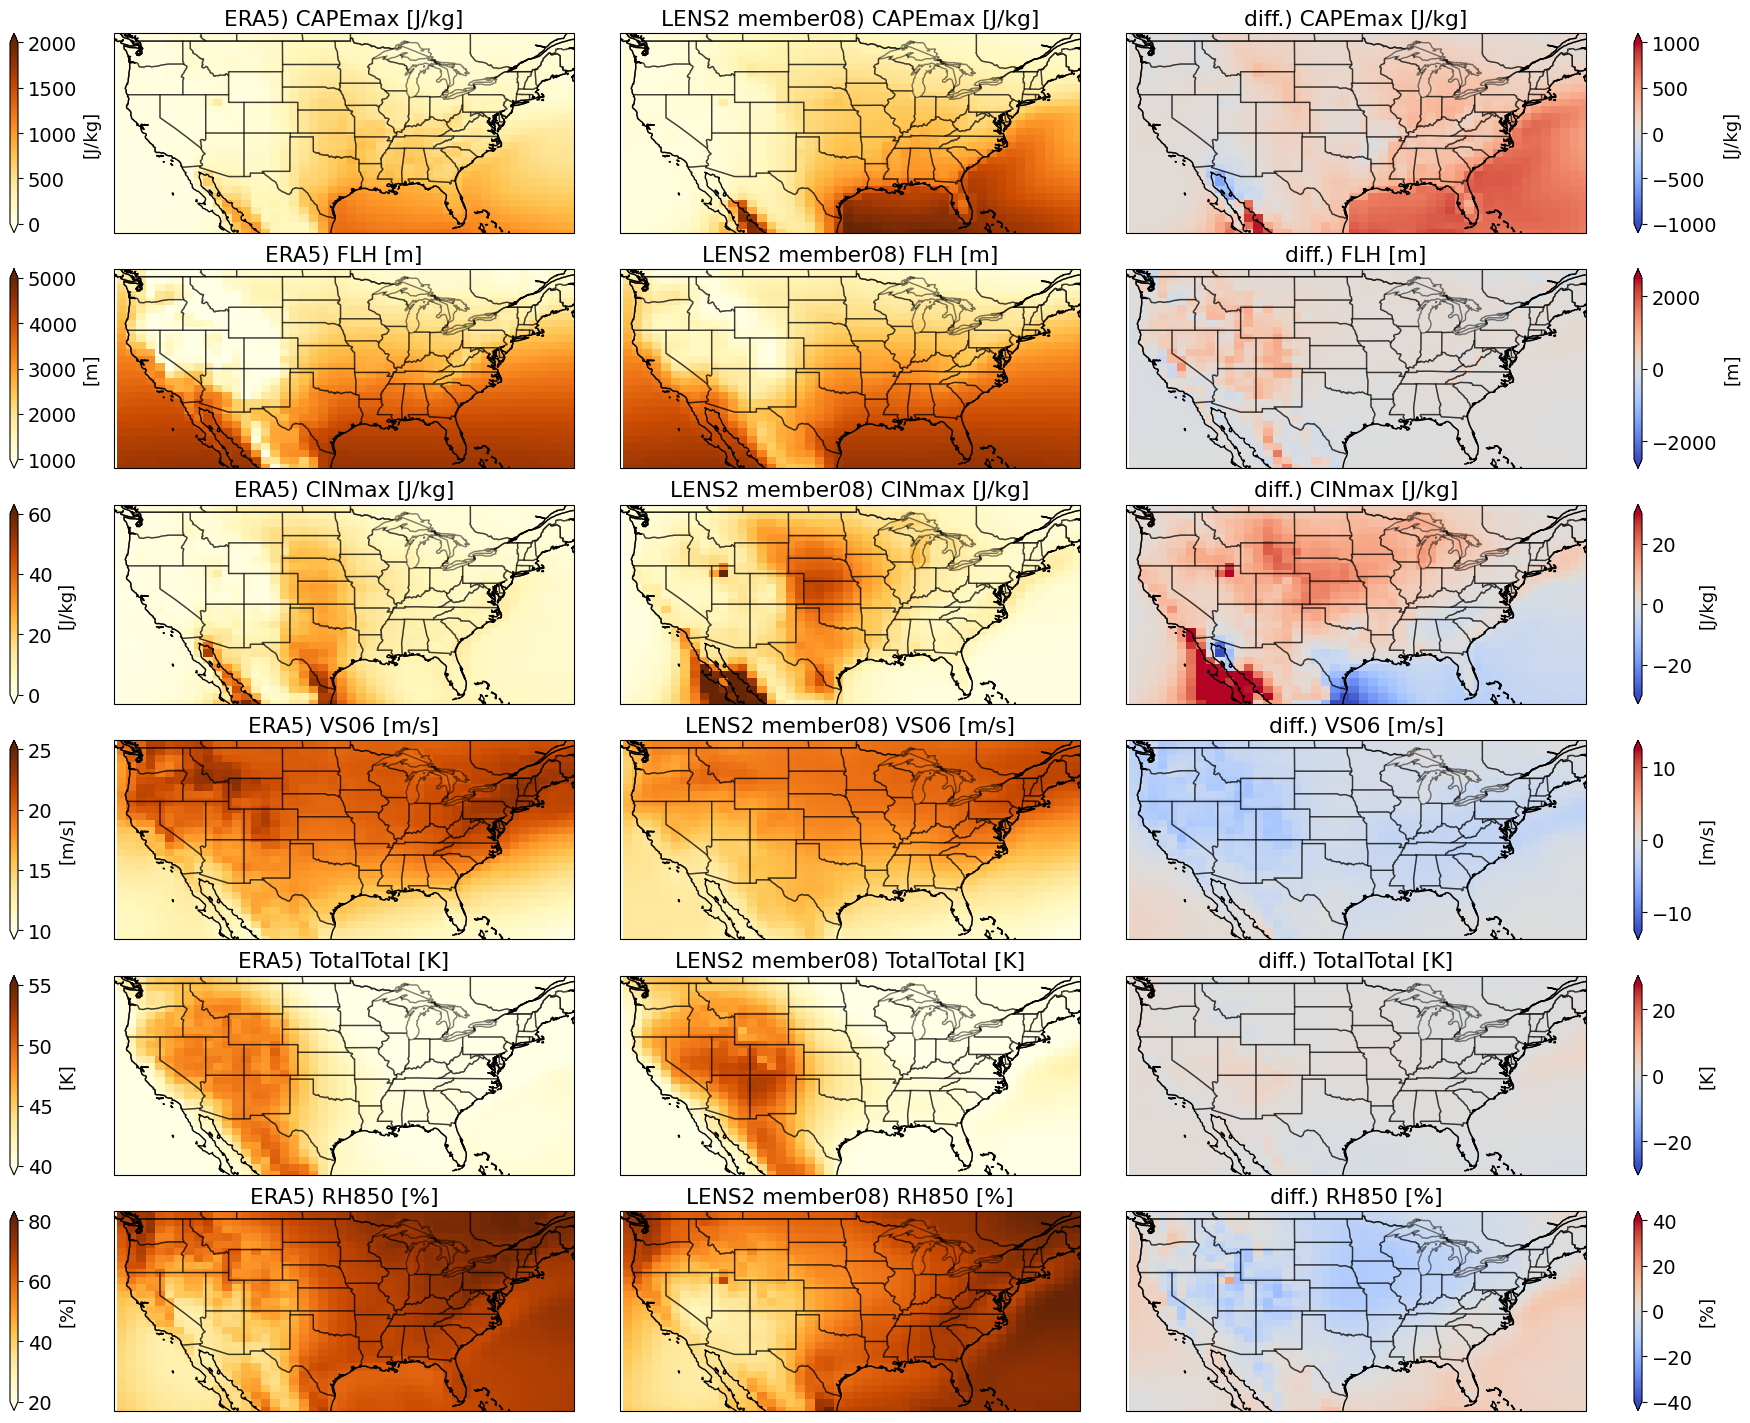

In [10]:
 
# set some plotting parameters for each variable
# ['CAPEmax', 'FLH', 'CINmax', 'VS06', 'TotalTotals', 'RH850']
vmin = [0,    1000, 0,  10, 40, 20]
vmax = [1500, 4000, 50, 25, 50, 70]
vmax = [2000, 5000, 60, 25, 55, 80]
units = ['J/kg','m','J/kg','m/s','K','%']

fig = plt.figure(figsize=(16, 16))
plt.rcParams.update({"font.size": 13})
gs1 = gridspec.GridSpec(n_var, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

datasets = ['ERA5', 'LENS2 member' + mem_s, 'diff.']
for va in tqdm(range(n_var)):
    for da in range(len(datasets)):
        ax = plt.subplot(gs1[va, da], projection=ccrs.PlateCarree())
            
        # Plot data
        if da == 0:
            data_act = np.mean(rgrERAVarall[:,va,:,:], axis=0)
        if da == 1:
            data_act = np.nanmean(lens_current[:,:,:,va,0], axis=0)
                
        if da == 2:
            data_act = np.nanmean(lens_current[:,:,:,va,0], axis=0) - np.mean(rgrERAVarall[:,va,:,:], axis=0)

        if da != 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='YlOrBr', transform=ccrs.PlateCarree(),
                      vmin = vmin[va], vmax = vmax[va])
        if da == 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin = -vmax[va]/2, vmax = vmax[va]/2)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
        # Add US states
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
        
        # Set extent to North America
        ax.set_extent([-126, -66, 24, 50], crs=ccrs.PlateCarree())
        
        # # Add gridlines
        # ax.gridlines(draw_labels=True)
        
        # Title
        plt.title(datasets[da] +') '+ lens_var_names[va]+' ['+units[va]+']')

        # Add a colorbar
        if da == 0:
            pos1 = ax.get_position()
            CbarAx = plt.axes([-0.025, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
        if da == 2:
            pos1 = ax.get_position()
            CbarAx = plt.axes([0.99, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14) 

plt.show()


- LENS2 current climate vs. future climate

100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


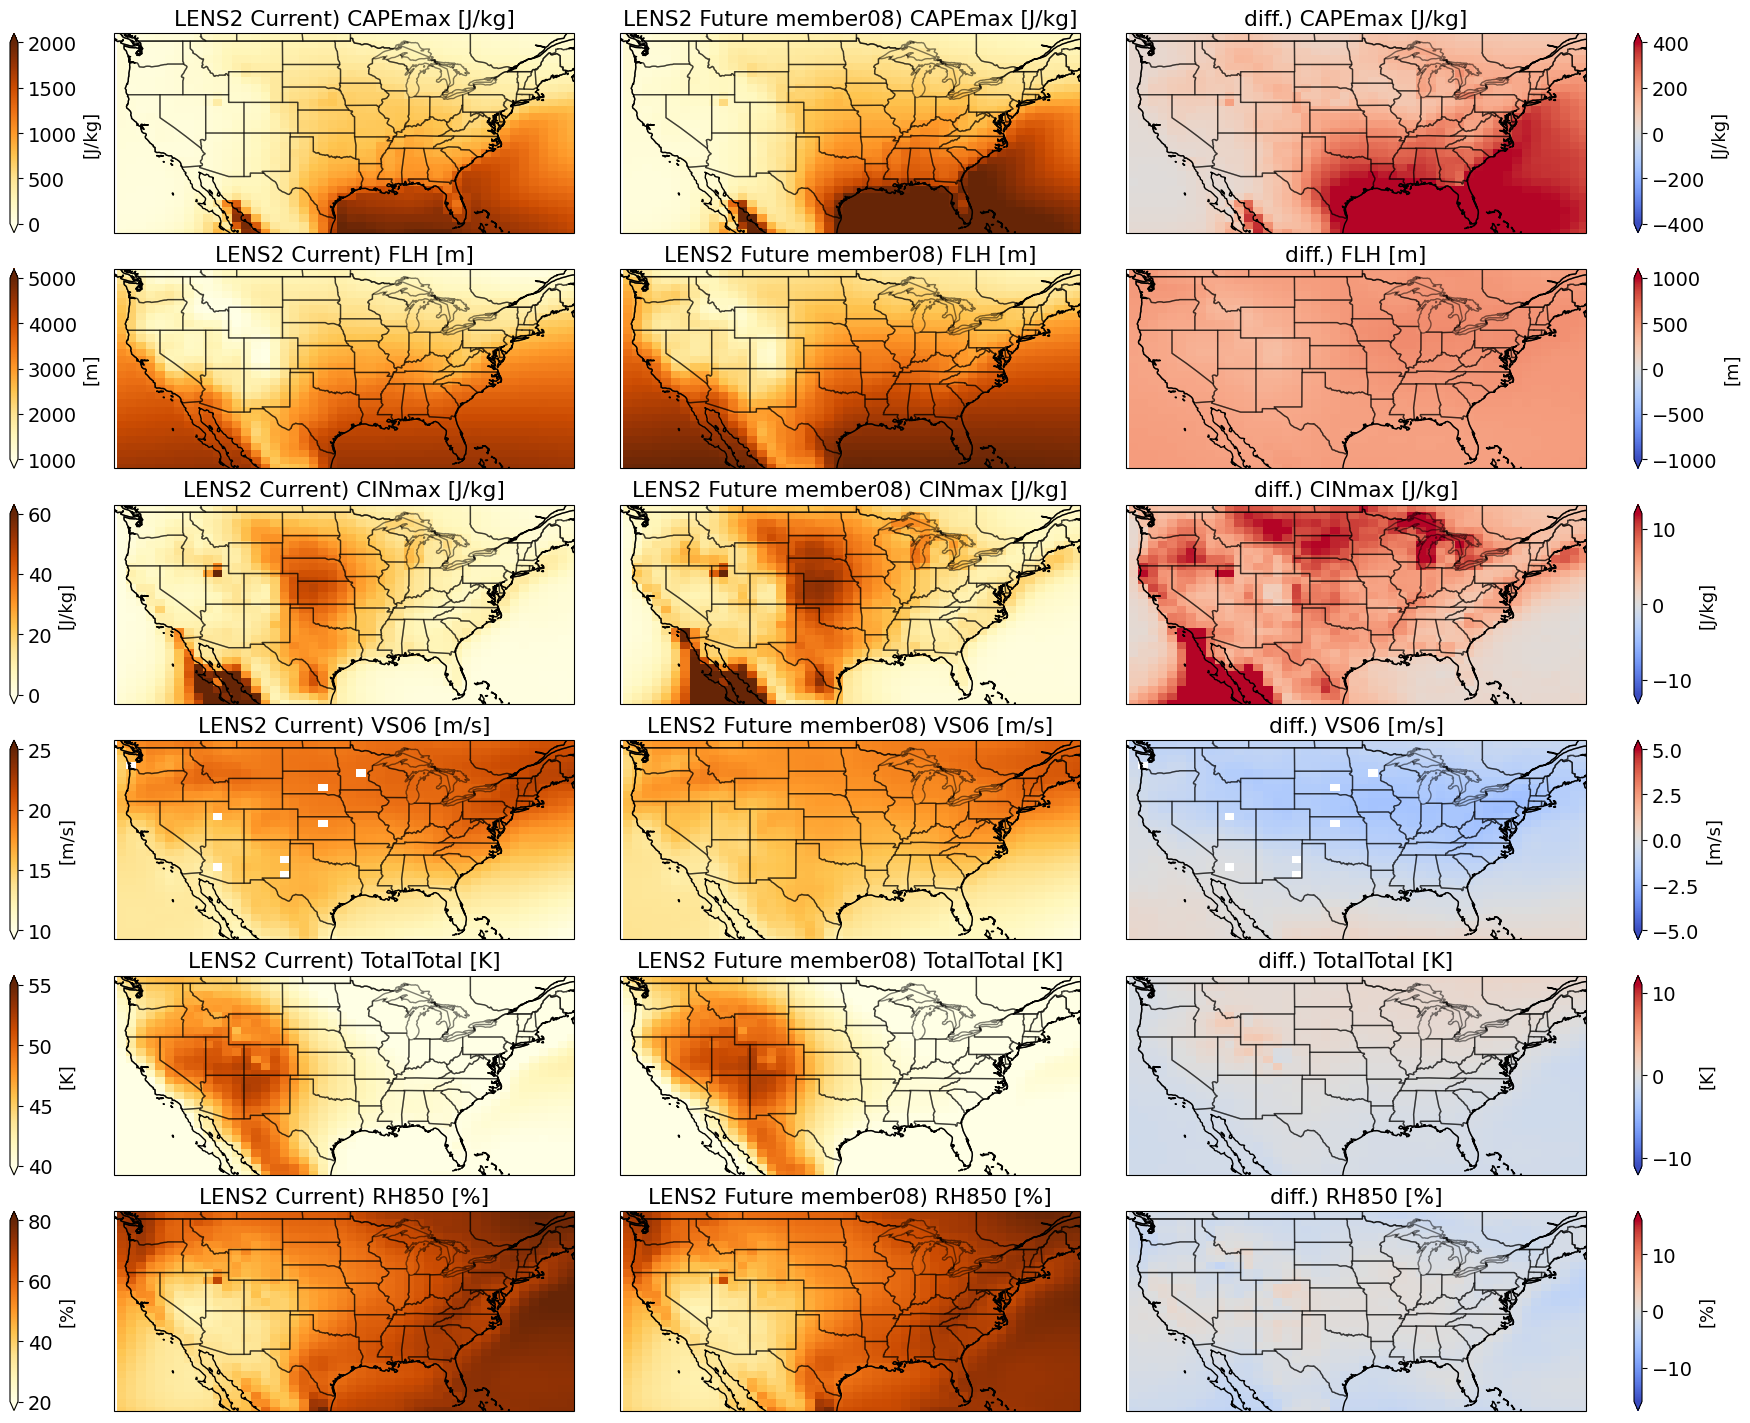

In [11]:
 
# set some plotting parameters for each variable
# ['CAPEmax', 'FLH', 'CINmax', 'VS06', 'TotalTotals', 'RH850']
vmin = [0,    1000, 0,  10, 40, 20]
vmax = [1500, 4000, 50, 25, 50, 70]
vmax = [2000, 5000, 60, 25, 55, 80]
units = ['J/kg','m','J/kg','m/s','K','%']

fig = plt.figure(figsize=(16, 16))
plt.rcParams.update({"font.size": 13})
gs1 = gridspec.GridSpec(n_var, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

datasets = ['LENS2 Current', 'LENS2 Future member' + mem_s, 'diff.']
for va in tqdm(range(n_var)):
    for da in range(len(datasets)):
        ax = plt.subplot(gs1[va, da], projection=ccrs.PlateCarree())
            
        # Plot data
        if da == 0:
            data_act = np.mean(lens_current[:,:,:,va,0], axis=0)
        if da == 1:
            data_act = np.nanmean(lens_future[:,:,:,va,0], axis=0)
                
        if da == 2:
            data_act = np.nanmean(lens_future[:,:,:,va,0], axis=0) - np.mean(lens_current[:,:,:,va,0], axis=0)

        if da != 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='YlOrBr', transform=ccrs.PlateCarree(),
                      vmin = vmin[va], vmax = vmax[va])
        if da == 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin = -vmax[va]/5, vmax = vmax[va]/5)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
        # Add US states
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
        
        # Set extent to North America
        ax.set_extent([-126, -66, 24, 50], crs=ccrs.PlateCarree())
        
        # # Add gridlines
        # ax.gridlines(draw_labels=True)
        
        # Title
        plt.title(datasets[da] +') '+ lens_var_names[va]+' ['+units[va]+']')

        # Add a colorbar
        if da == 0:
            pos1 = ax.get_position()
            CbarAx = plt.axes([-0.025, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
        if da == 2:
            pos1 = ax.get_position()
            CbarAx = plt.axes([0.99, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14) 

plt.show()

#### 3.2) with BC
- ERA5 vs. LENS2 BC (same)

100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


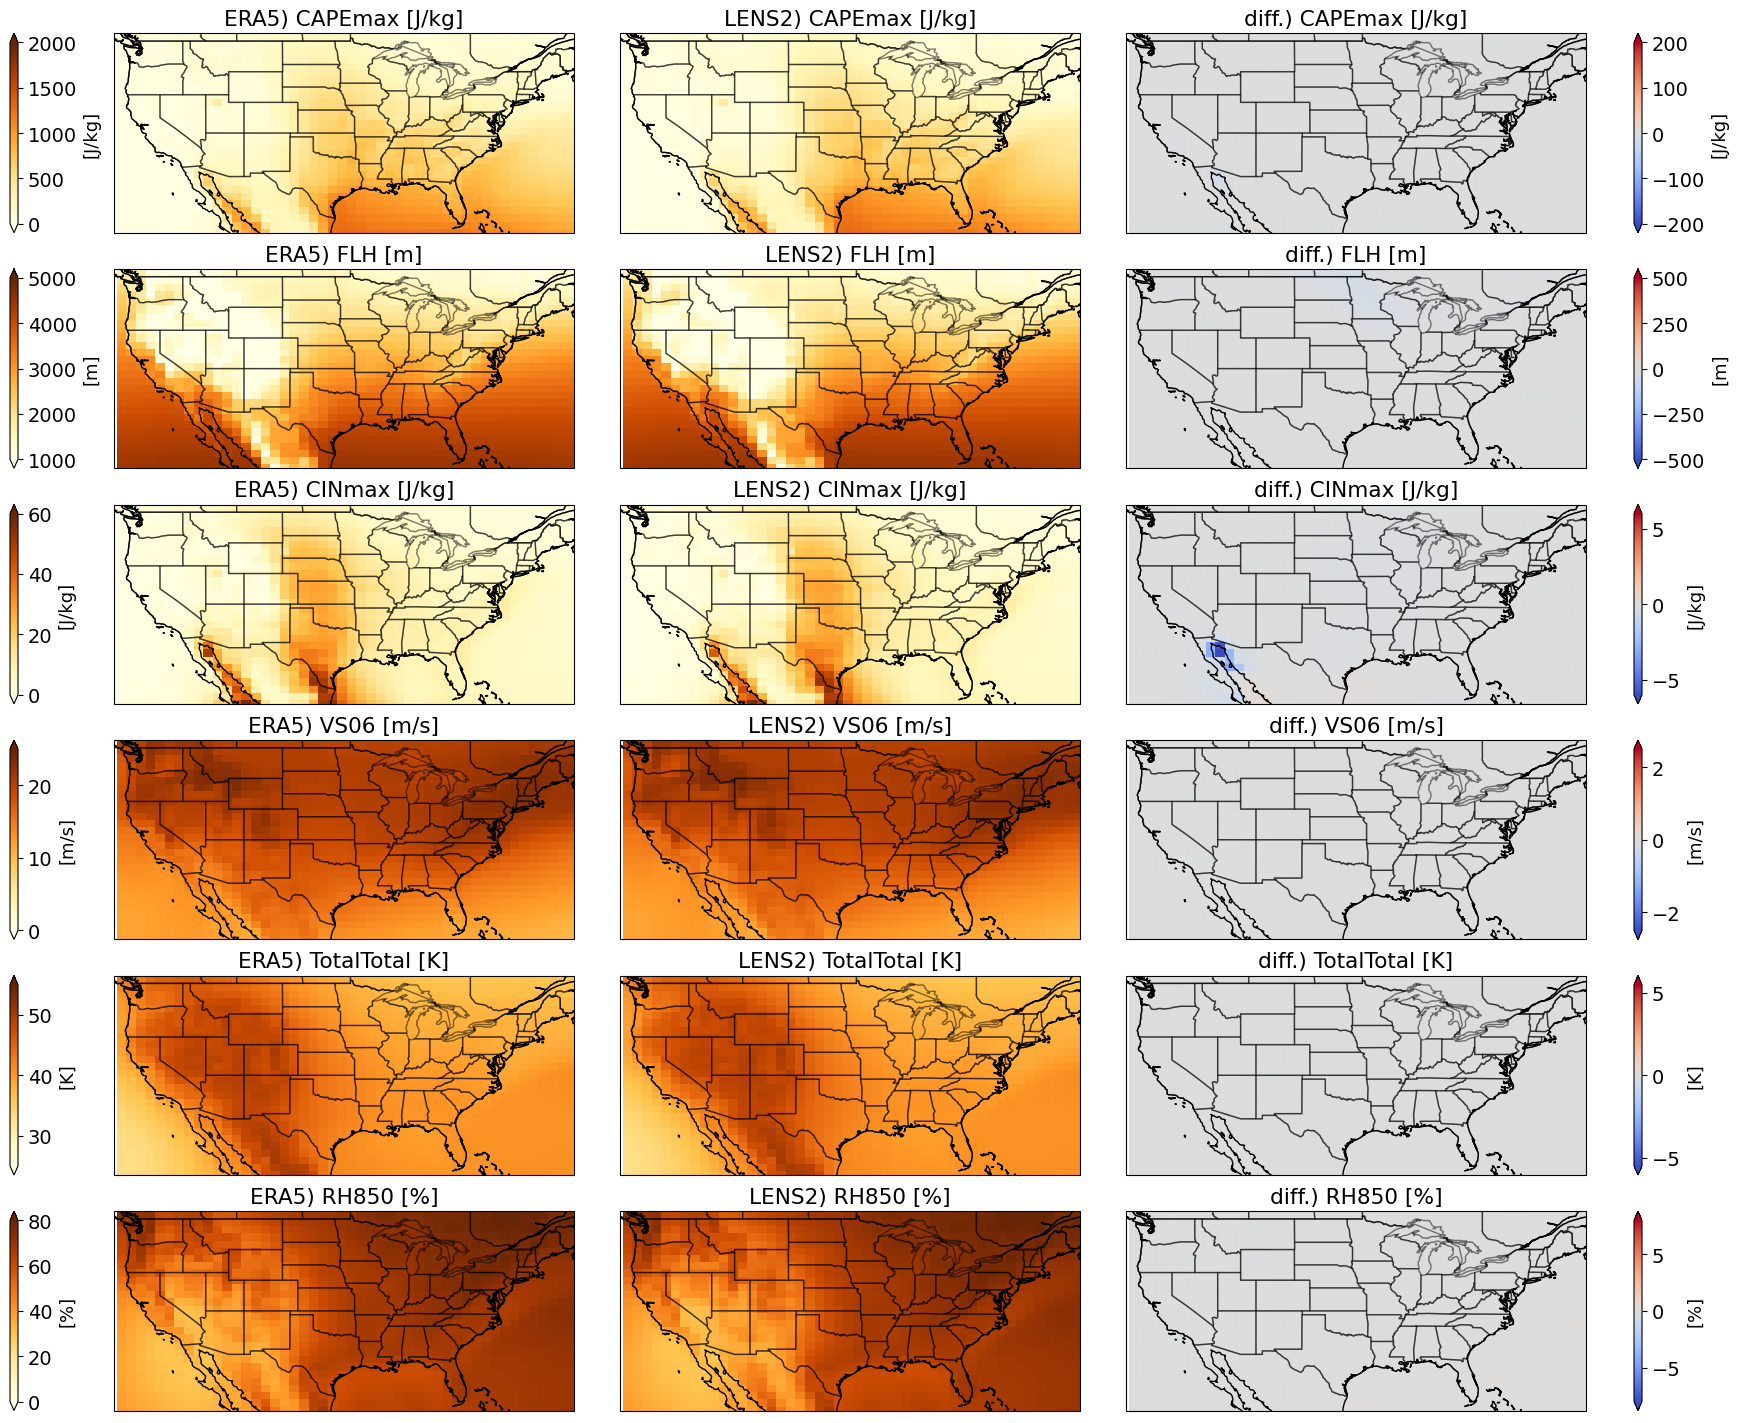

In [12]:
# set some plotting parameters for each variable
# ['CAPEmax', 'FLH', 'CINmax', 'VS06', 'TotalTotals', 'RH850']
vmin = [0,    1000, 0,  0,  25, 0]
vmax = [1500, 4000, 50, 25, 60, 80]
vmax = [2000, 5000, 60, 25, 55, 80]
units = ['J/kg','m','J/kg','m/s','K','%']

fig = plt.figure(figsize=(16, 16))
plt.rcParams.update({"font.size": 13})
gs1 = gridspec.GridSpec(n_var, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

datasets = ['ERA5', 'LENS2', 'diff.']
for va in tqdm(range(n_var)):
    for da in range(len(datasets)):
        ax = plt.subplot(gs1[va, da], projection=ccrs.PlateCarree())
            
        # Plot data
        if da == 0:
            data_act = np.mean(rgrERAVarall[:,va,:,:], axis=0)
        if da == 1:
            data_act = np.nanmean(lens_current_bc[:,:,:,va,0], axis=0)
        if da == 2:
            data_act = np.nanmean(lens_current_bc[:,:,:,va,0], axis=0) - np.mean(rgrERAVarall[:,va,:,:], axis=0)

        if da != 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='YlOrBr', transform=ccrs.PlateCarree(),
                      vmin = vmin[va], vmax = vmax[va])
        if da == 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin = -vmax[va]/10, vmax = vmax[va]/10)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
        # Add US states
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
        
        # Set extent to North America
        ax.set_extent([-126, -66, 24, 50], crs=ccrs.PlateCarree())
        
        # Title
        plt.title(datasets[da] +') '+ lens_var_names[va]+' ['+units[va]+']')

        # Add a colorbar
        if da == 0:
            pos1 = ax.get_position()
            CbarAx = plt.axes([-0.025, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
        if da == 2:
            pos1 = ax.get_position()
            CbarAx = plt.axes([0.99, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
    
plt.show()


- LENS2 current climate BC vs. future climate BC

100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


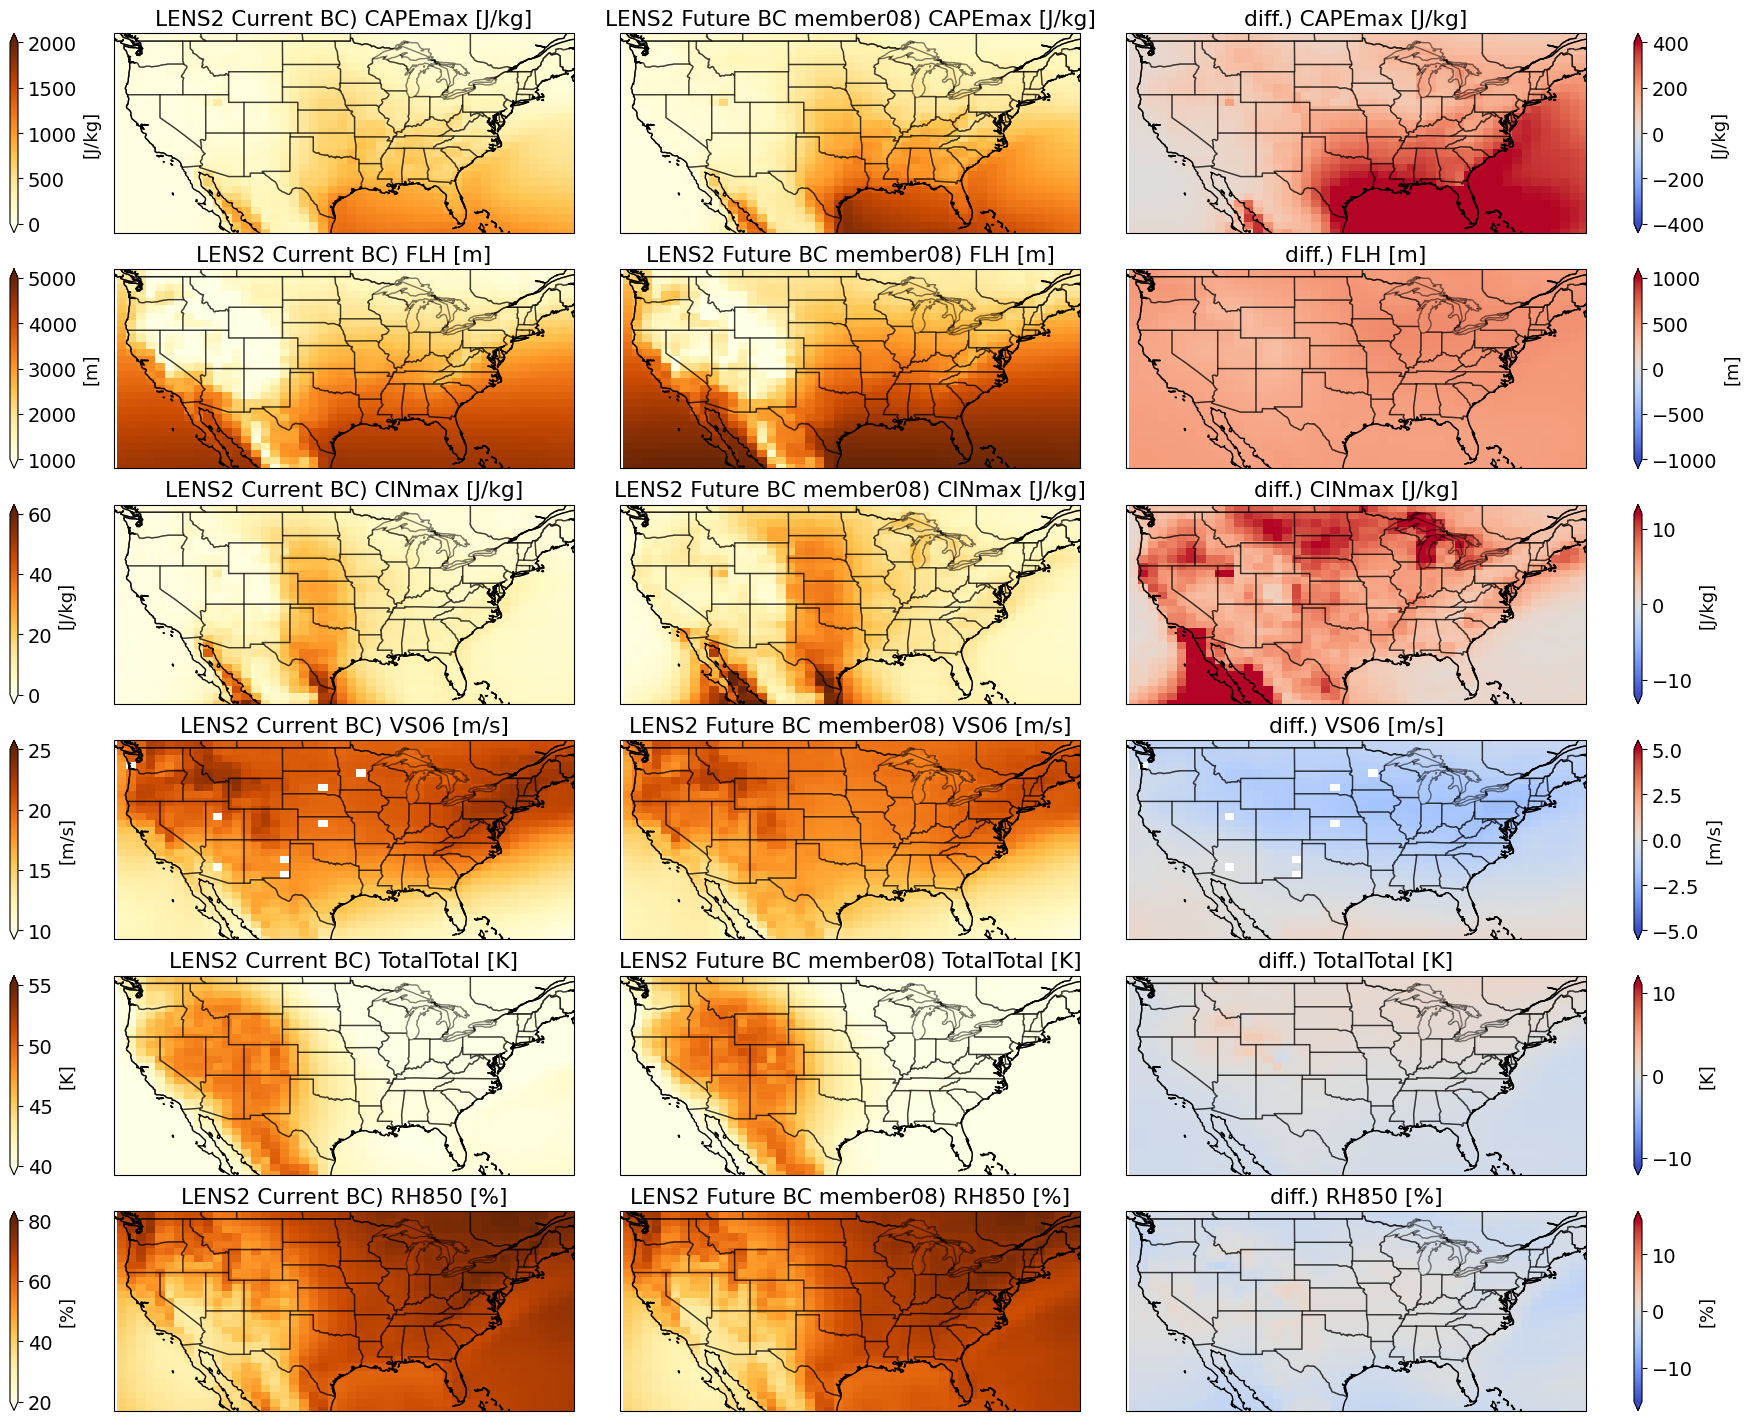

In [13]:
 
# set some plotting parameters for each variable
# ['CAPEmax', 'FLH', 'CINmax', 'VS06', 'TotalTotals', 'RH850']
vmin = [0,    1000, 0,  10, 40, 20]
vmax = [1500, 4000, 50, 25, 50, 70]
vmax = [2000, 5000, 60, 25, 55, 80]
units = ['J/kg','m','J/kg','m/s','K','%']

fig = plt.figure(figsize=(16, 16))
plt.rcParams.update({"font.size": 13})
gs1 = gridspec.GridSpec(n_var, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

datasets = ['LENS2 Current BC', 'LENS2 Future BC member' + mem_s, 'diff.']
for va in tqdm(range(n_var)):
    for da in range(len(datasets)):
        ax = plt.subplot(gs1[va, da], projection=ccrs.PlateCarree())
            
        # Plot data
        if da == 0:
            data_act = np.mean(lens_current_bc[:,:,:,va,0], axis=0)
        if da == 1:
            data_act = np.nanmean(lens_future_bc[:,:,:,va,0], axis=0)
                
        if da == 2:
            data_act = np.nanmean(lens_future_bc[:,:,:,va,0], axis=0) - np.mean(lens_current_bc[:,:,:,va,0], axis=0)

        if da != 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='YlOrBr', transform=ccrs.PlateCarree(),
                      vmin = vmin[va], vmax = vmax[va])
        if da == 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin = -vmax[va]/5, vmax = vmax[va]/5)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
        # Add US states
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
        
        # Set extent to North America
        ax.set_extent([-126, -66, 24, 50], crs=ccrs.PlateCarree())
        
        # # Add gridlines
        # ax.gridlines(draw_labels=True)
        
        # Title
        plt.title(datasets[da] +') '+ lens_var_names[va]+' ['+units[va]+']')

        # Add a colorbar
        if da == 0:
            pos1 = ax.get_position()
            CbarAx = plt.axes([-0.025, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
        if da == 2:
            pos1 = ax.get_position()
            CbarAx = plt.axes([0.99, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14) 

plt.show()

<xarray.Dataset> Size: 1GB
Dimensions:         (year: 55, Julian_day: 365, lat: 28, lon: 48, variable: 6)
Coordinates:
  * year            (year) int64 440B 1960 1961 1962 1963 ... 2012 2013 2014
  * Julian_day      (Julian_day) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
  * lat             (lat) float64 224B 24.03 24.97 25.92 ... 47.59 48.53 49.48
  * lon             (lon) float64 384B 235.0 236.2 237.5 ... 291.2 292.5 293.8
  * variable        (variable) <U10 240B 'CAPEmax' 'FLH' ... 'RH850'
Data variables:
    hailpredictors  (year, Julian_day, lat, lon, variable) float64 1GB ...


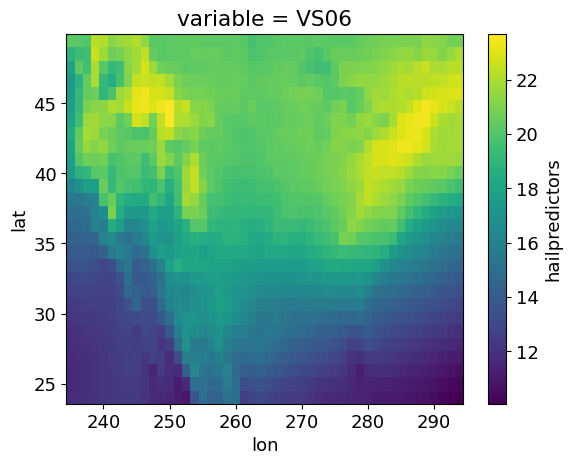

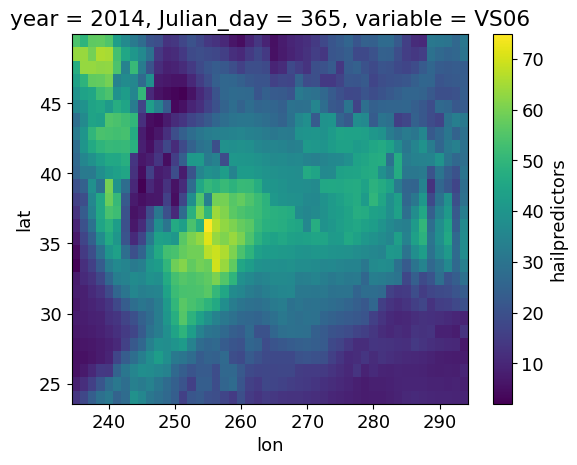

In [54]:
flnm = dir_o + 'hailpredictors_lens_08_corrected.nc'
with xr.open_dataset(flnm, engine ='netcdf4') as ds:
    print(ds)
    ds.hailpredictors[:, :,:,:,3].mean(dim=['year', 'Julian_day']).plot()
    #print(*aa)
    plt.show()

flnm = dir_o + 'hailpredictors_lens_02_corrected.nc'
with xr.open_dataset(flnm, engine ='netcdf4') as ds:
    #print(ds)
    ds.hailpredictors[54, 364,:,:,3].plot() 
    plt.show()